<a href="https://colab.research.google.com/github/milanfx/DTSA-5511/blob/main/NLP_Disaster_Tweets_Kaggle_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="font-family:Roboto Condensed SemiBold; font-size:150%; letter-spacing: 0px; background-color:darkgreen; color:#f8f2e4; text-align:center; padding-top:10px; padding-bottom:10px; border: 5px solid #f8f2e4; border-radius: 20px;"><h1><b>
NLP Disaster Tweets Kaggle Mini-Project
</b></h1></div>

---

<div style="text-align:center">
<img src="https://github.com/milanfx/Dataset/blob/main/images/nlp_logo.png?raw=true" style="width:850px; height:200px;">
</div>


<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **1. Project Introduction**

</div>

---

### **1.1 Project understanding**

**Background:**

- This Kaggle competition focuses on enhancing emergency response efforts by developing a machine learning model that can accurately identify tweets about real disasters.

- The real-time nature of Twitter makes it a vital tool for disaster relief organizations and news agencies to monitor and respond to emergencies.


**Objective:**

- This project employs Long Short-Term Memory (LSTM) networks to effectively distinguish between tweets that refer to actual disasters and those that do not.

- The final model aims to achieve at least 80% score in classifying disaster-related tweets while maintaining reasonable computational efficiency.

- Evaluating the final model's performance will highlight key areas for further improvements, guiding future enhancements in NLP disaster detection.


**Chanllenge:**

- Tweets often contain ambiguous language and metaphorical expressions, making it difficult for models to accurately interpret their meaning.

- Text data often has high dimensionality and sparsity, making models prone to memorizing specific patterns in the training data rather than learning general features.

---

### **1.2 Data Understanding**

**Data Description**

- The dataset comprises 10k tweets, with 7.6k for training and 3.2k for testing, and each tweet contains a few to about 100 words.

**Evaluation Method**

- The model is evaluated using the F1 score, which measures both precision and recall.

- The optimal solution would achieve an F1 score of 1, indicating perfect classification without any false positives or false negatives.


---

### **1.3 Data Loading**

**Load Library:**

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import os
import warnings
import requests
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SpatialDropout1D, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Load Data from Kaggle:**

In [115]:
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
!kaggle competitions download -c nlp-getting-started
!unzip -q nlp-getting-started -d dataset

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
replace dataset/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  
error:  invalid response [ ]
replace dataset/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace dataset/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  
error:  invalid response [ ]
replace dataset/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace dataset/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  
error:  invalid response [ ]
replace dataset/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


**Check Data Size:**

In [116]:
train_path = '/content/dataset/train.csv'
test_path = '/content/dataset/test.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f'Train Data Size: {train.shape}')
print(f'Test Data Size: {test.shape}')

Train Data Size: (7613, 5)
Test Data Size: (3263, 4)


**Preview Train and Test Data**

In [117]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [118]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


- The train and test datasets have been loaded for further preprocessing and analysis.

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **2. Exploratory Analysis**

</div>

---

### **2.1 Sample Distribution**

**Check the Proportion of Negative and Positive samples:**

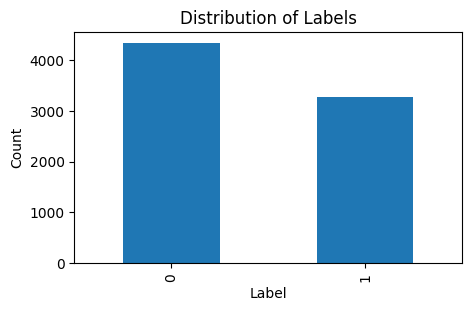

In [119]:
plt.figure(figsize=(5, 3))
train['target'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [120]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

- The ratio of positive to negative samples stands at 3:4; thus, rebalancing may be considered, though it is not required.

---

### **2.2 Sample Comparison**

**Word Cloud:**

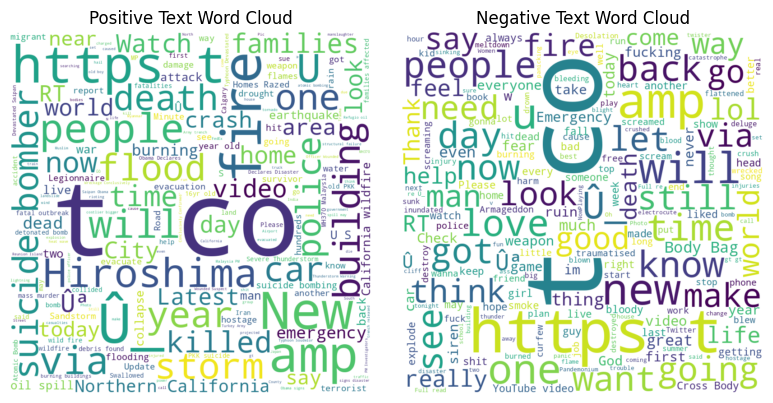

In [121]:
positive_text = ' '.join(train[train['target'] == 1]['text'])
negative_text = ' '.join(train[train['target'] == 0]['text'])

positive_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(negative_text)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Text Word Cloud', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Text Word Cloud', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

- The popular words in positive and negative samples are almost the same, indicating that further cleaning is necessary.

---

### **2.3 Further Cleaning**

**Cleaning Process:**

- Replace &amp with &

- Remove URLs

- Remove HTML tags

- Remove punctuations

- Remove numbers

- Remove non-ASCII characters

- Convert to lowercase

- Remove stopwords and lemmatize

In [122]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
custom_stop_words = set(["u", "im", "one", "new", "like", "get", "know", "go", "day", "time", "make", "people"])

stop_words = stop_words.union(custom_stop_words)

def clean_text(text):
    # Replace &amp; with &
    text = text.replace('&amp;', '&')
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords and lemmatize
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

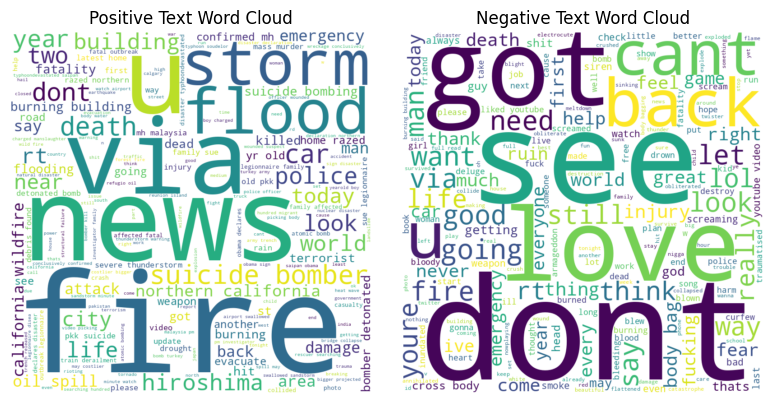

In [123]:
train['clean_text'] = train['text'].apply(clean_text)
test['clean_text'] = test['text'].apply(clean_text)

positive_text = ' '.join(train[train['target'] == 1]['clean_text'])
negative_text = ' '.join(train[train['target'] == 0]['clean_text'])

positive_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=STOPWORDS).generate(negative_text)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Text Word Cloud', fontsize=12)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Text Word Cloud', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

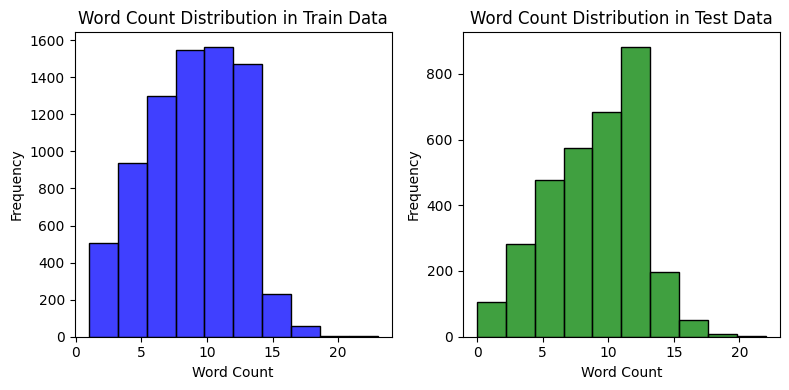

In [124]:
train['word_count'] = train['clean_text'].apply(lambda x: len(x.split()))
test['word_count'] = test['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.histplot(train['word_count'], bins=10, kde=False, color='blue')
plt.title('Word Count Distribution in Train Data')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test['word_count'], bins=10, kde=False, color='green')
plt.title('Word Count Distribution in Test Data')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- After further cleaning, we can see obvious difference in positive and negative samples.

---

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **3. Model Architecture**

</div>

---

### **3.1 Split Train and Validation**

**Split into 80% and 20%:**

In [129]:
train_set, val_set = train_test_split(train, test_size=0.2, random_state=1)
X_train = train_set['clean_text']
y_train = train_set['target']

X_val = val_set['clean_text']
y_val = val_set['target']

X_test = test['clean_text']

-

---

### **3.1 tokenizer with xgboost**

**tokenizer Vectorization:**

-

In [126]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
len(word_index)

13419

In [130]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 20
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

**Baseline Model:**

In [131]:
xgb_token = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

xgb_token.fit(X_train_pad, y_train)

y_val_pred = xgb_token.predict(X_val_pad)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.77      0.73       882
           1       0.63      0.55      0.58       641

    accuracy                           0.67      1523
   macro avg       0.66      0.66      0.66      1523
weighted avg       0.67      0.67      0.67      1523



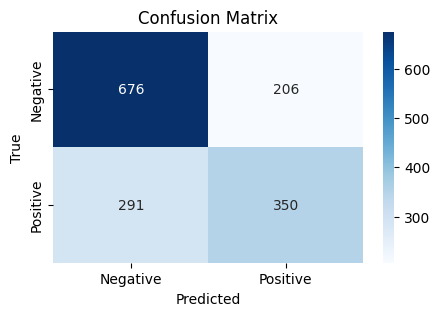

In [132]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [135]:
predictions = xgb_token.predict(X_test_pad)
result = pd.DataFrame({
    "id": test['id'],
    "target": predictions
})
result.to_csv('xgb_token.csv', index=False)

- LB result is 0.665

---

### **3.2 TF-IDF with xgboost**

In [138]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [141]:
xgb_tfidf = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
xgb_tfidf.fit(X_train_tfidf, y_train)
y_val_pred = xgb_tfidf.predict(X_val_tfidf)
print("Classification Report:\n", classification_report(y_val, y_val_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.88      0.82       882
           1       0.80      0.63      0.70       641

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.76      1523
weighted avg       0.78      0.78      0.77      1523



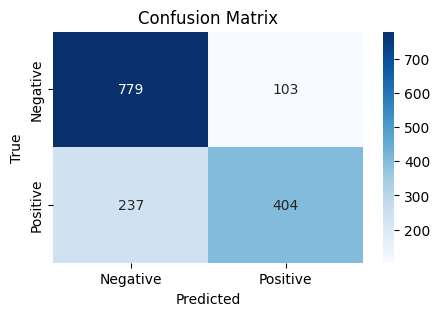

In [142]:
conf_matrix = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [143]:
predictions = xgb_tfidf.predict(X_test_tfidf)
result = pd.DataFrame({
    "id": test['id'],
    "target": predictions
})
result.to_csv('xgb_tfidf.csv', index=False)

- LB result is 0.775

### **3.3 GloVe with LSTM**

**The model is**

-

In [105]:
def f1_m(y_true, y_pred):
    def precision_m(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
        return precision

    def recall_m(y_true, y_pred):
        true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
        possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
        return recall

    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [106]:
local_path = '/content/glove.6B.100d.txt'

def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_index = load_glove_embeddings(local_path)

In [107]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

maxlen = 20

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen, padding='post')

embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [108]:
X_train_pad.shape

(6090, 20)

In [111]:
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
          input_length=20, trainable=False))
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.005))))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.005)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.005)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 20, 100)           1342000   
                                                                 
 bidirectional_19 (Bidirect  (None, 256)               234496    
 ional)                                                          
                                                                 
 dropout_52 (Dropout)        (None, 256)               0         
                                                                 
 dense_51 (Dense)            (None, 64)                16448     
                                                                 
 dropout_53 (Dropout)        (None, 64)                0         
                                                                 
 dense_52 (Dense)            (None, 16)                1040      
                                                     

In [112]:
from keras.optimizers import Adam

adam = Adam(learning_rate=0.0001)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])

# Early stopping based on F1 score
early_stopping = EarlyStopping(monitor='val_f1_m', mode='max', patience=8, verbose=1, restore_best_weights=True)

# Train the model
model.fit(X_train_pad, y_train, epochs=50, batch_size=32, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

Epoch 1/50
191/191 [==============================] - 6s 12ms/step - loss: 1.1220 - accuracy: 0.7696 - f1_m: 0.6845 - val_loss: 0.6258 - val_accuracy: 0.7814 - val_f1_m: 0.7136
Epoch 2/50
191/191 [==============================] - 2s 8ms/step - loss: 0.5726 - accuracy: 0.7908 - f1_m: 0.7356 - val_loss: 0.5495 - val_accuracy: 0.7892 - val_f1_m: 0.7338
Epoch 3/50
191/191 [==============================] - 1s 8ms/step - loss: 0.5277 - accuracy: 0.7990 - f1_m: 0.7393 - val_loss: 0.5118 - val_accuracy: 0.7905 - val_f1_m: 0.7274
Epoch 4/50
191/191 [==============================] - 1s 8ms/step - loss: 0.5071 - accuracy: 0.8016 - f1_m: 0.7452 - val_loss: 0.5068 - val_accuracy: 0.7873 - val_f1_m: 0.7411
Epoch 5/50
191/191 [==============================] - 1s 8ms/step - loss: 0.4967 - accuracy: 0.8026 - f1_m: 0.7461 - val_loss: 0.5122 - val_accuracy: 0.7866 - val_f1_m: 0.7086
Epoch 6/50
191/191 [==============================] - 1s 8ms/step - loss: 0.4884 - accuracy: 0.8102 - f1_m: 0.7588 - va

-

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **4. Results and Analysis**

</div>

---

### **4.1 Model Performance**

**Accuracy:**

**Loss:**

**AUC:**

-


**Confusion Marix:**

- Based on the confusion matrix, we can observe a balanced distribution of misclassified samples.

---

### **4.2 Prediction Accuracy**

<div style="text-align:center">
<img src="" style="width:850px;">
</div>


-

---

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:darkgreen; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid darkgreen; border-radius: 20px;">

## **5. Project Conclusion**

</div>

---

### **5.1 Model Summary**

1.

2.

3. The shortcomings of this model include:

-

---

### **5.2 Next Step**

1.

2.

3.

---

In [ ]:
embeddings_index = {}
with open("/kaggle/input/glove6b/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")